In [1]:
import numpy as np
import scipy.signal
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.pixel_grid import PixelGrid
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

np.random.seed(41)

In [2]:
psf_filename = 'SPT0311-58_cont_natural_selfcalp1.psf.fits'
image_filename = 'SPT0311-58_cont_natural_selfcalp1_dirty.image.fits'
pb_filename = 'SPT0311-58_cont_natural_selfcalp1.pb.fits'

In [3]:
Length = 450
x_cut_start = 1165
y_cut_start = 1275

dirty_image = pyfits.getdata(image_filename)
dirty_image = dirty_image[0][0]
dirty_image_cut = dirty_image[y_cut_start:y_cut_start+Length:1,x_cut_start:x_cut_start+Length:1]

pb = pyfits.getdata(pb_filename)
pb_cut = pb[0][0][y_cut_start:y_cut_start+Length:1,x_cut_start:x_cut_start+Length:1]

psf = pyfits.getdata(psf_filename)
psf_cut = psf[0][0][1500-450:1500+451:1,1500-450:1500+451:1]

In [4]:
west_convolved = np.load('west_pixel_e1_0323_e2_n0322_lensed_convolved.npy')

In [5]:
dirty_image_east_only = dirty_image_cut - west_convolved

<ipython-input-6-2860f2d96fad>:8: RuntimeWarning: invalid value encountered in log10
  cr2 = r2.matshow(np.log10(psf_cut),origin='lower')


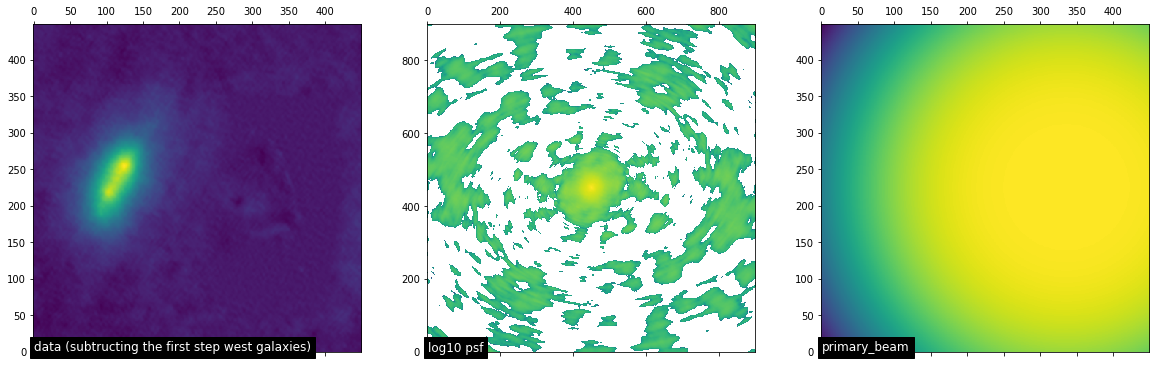

In [6]:
fig = plt.figure(figsize=(20,12))

r1 = fig.add_subplot(131)
cr1 = r1.matshow(dirty_image_east_only,origin='lower')
r1.text(1, 1, 'data (subtructing the first step west galaxies)', fontsize=12,c='w',backgroundcolor='black')

r2 = fig.add_subplot(132)
cr2 = r2.matshow(np.log10(psf_cut),origin='lower')
r2.text(1, 1, 'log10 psf', fontsize=12,c='w',backgroundcolor='black')

r3 = fig.add_subplot(133)
cr3 = r3.matshow(pb_cut,origin='lower')
r3.text(1, 1, 'primary_beam', fontsize=12,c='w',backgroundcolor='black')

plt.show()

In [7]:
# data specifics
background_rms = 7.48e-6  #  background noise per pixel (Gaussian rms value)
exp_time = np.inf  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 450  #  cutout pixel size
deltaPix = 0.008  #  pixel size in arcsec (area per pixel = deltaPix**2)

# define the data class
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
kwargs_data['antenna_primary_beam'] = pb_cut  # put primary beam here
kwargs_data['likelihood_method'] = 'interferometry_natwt'
kwargs_data['image_data'] = dirty_image_east_only # Here input the image containing only the east galaxies as data image
kwargs_data['ra_at_xy_0']=-(1500-1165)*deltaPix 
kwargs_data['dec_at_xy_0']=-(1500-1275)*deltaPix
data_class = ImageData(**kwargs_data)

In [8]:
# define the psf class
kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix,
              'kernel_point_source': psf_cut, 'kernel_point_source_normalisation': False}
psf_class = PSF(**kwargs_psf)

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\lenstronomy\Data\psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


In [9]:
# define the lens model class

kwargs_SIE_Caustics_Calibrated = {'theta_E': 0.331,
  'gamma': 2.0,
  'e1': 0.323,
  'e2': -0.322,
  'center_x': -0.368,
  'center_y': -0.142}

kwargs_SIE_fitting = {'theta_E': 0.33178176767176526,
   'gamma': 2.0,
   'e1': 0.3367177648186059,
   'e2': -0.43799608752954816,
   'center_x': -0.3732630056628361,
   'center_y': -0.13944499261050985}

lens_model_list = ['EPL']
kwargs_lens = [kwargs_SIE_Caustics_Calibrated] # Change the lens model to get the different reconstruction
lens_model_class = LensModel(lens_model_list=lens_model_list)

In [10]:
# define the source pixel grid class
# Here we define a different source region that only covers the east galaxies

source_pixel_width = deltaPix
source_pixel_num_x_axis = 120
source_pixel_num_y_axis = 140
ra_at_xy_0_source = -(1500-1165-100)*deltaPix
dec_at_xy_0_source = -(1500-1275-180)*deltaPix

transform_pix2angle = source_pixel_width * np.identity(2)
source_pixel_grid_class = PixelGrid(nx = source_pixel_num_x_axis, ny = source_pixel_num_y_axis, 
                                    transform_pix2angle = transform_pix2angle, 
                                    ra_at_xy_0 = ra_at_xy_0_source, dec_at_xy_0 = dec_at_xy_0_source)

In [11]:
# Define the PixelatedSourceReconstruction class
from lenstronomy.ImSim.SourceReconstruction.pixelated_source_reconstruction import PixelatedSourceReconstruction
PSR = PixelatedSourceReconstruction(data_class, psf_class, lens_model_class, source_pixel_grid_class)

In [12]:
# Construct the M and b
# It should take less than one hour, faster than the west reconstructions due to fewer pixels
M_pixel, b_pixel = PSR.generate_M_b(kwargs_lens, verbose=True, show_progress=True)

number of source pixels: 16800 (x axis: 120 pixels;  y axis: 140 pixels)
likelihood method: interferometry_natwt
Step 1: Lensing the source pixels


Running (iteration times vary):   0%|          | 2/16800 [00:00<22:57, 12.20it/s]

Step 1: Finished!
Step 2: Compute the matrix M and vector b (including the convolution step)


Running (iteration times vary): 100%|██████████| 16800/16800 [14:02<00:00, 19.94it/s]


Step 2: Finished!


In [13]:
# Generate the regularization matrix
from lenstronomy.ImSim.SourceReconstruction.regularization_matrix_pixel import pixelated_regularization_matrix

In [14]:
U_pixel = pixelated_regularization_matrix(120, 140, 'gradient')

- Here we just use the same regularization strength solved in the first step to keep the source prior the same across the source plane

In [15]:
U_pixel *= 920353395596.8142

In [16]:
source_pixel_amps = np.linalg.solve(M_pixel + U_pixel, b_pixel)

In [17]:
image_source_recon_east = np.zeros((numPix,numPix))
image_source_recon_east[180: 180+140, 100: 100+120] = source_pixel_amps.reshape(140,120)

In [18]:
image_lensed_recon_east = PSR.lens_an_image_by_rayshooting(kwargs_lens, source_pixel_amps.reshape(140,120))

In [19]:
image_lensed_convolved_east = scipy.signal.fftconvolve(pb_cut * image_lensed_recon_east, psf_cut,mode='same')

In [20]:
residual = (dirty_image_east_only - image_lensed_convolved_east)

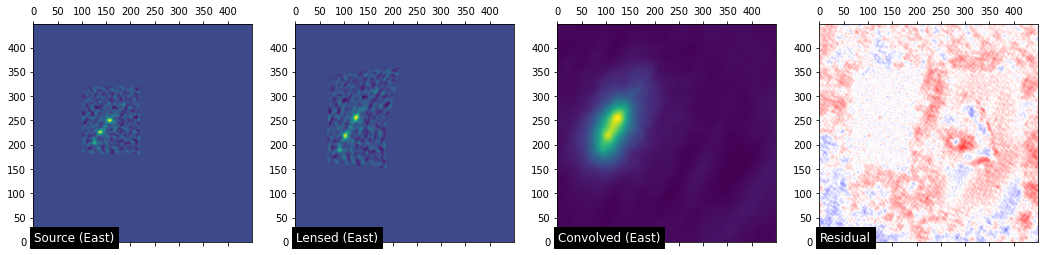

In [21]:
fig = plt.figure(figsize=(18,12))

r1 = fig.add_subplot(141)
cr1 = r1.matshow(image_source_recon_east,origin='lower')
r1.text(1, 1, 'Source (East)', fontsize=12,c='w',backgroundcolor='black')

r1 = fig.add_subplot(142)
cr1 = r1.matshow(image_lensed_recon_east,origin='lower')
r1.text(1, 1, 'Lensed (East)', fontsize=12,c='w',backgroundcolor='black')

r1 = fig.add_subplot(143)
cr1 = r1.matshow(image_lensed_convolved_east,origin='lower')
r1.text(1, 1, 'Convolved (East)', fontsize=12,c='w',backgroundcolor='black')

r1 = fig.add_subplot(144)
cr1 = r1.matshow(residual / background_rms,cmap='bwr',vmin=-6,vmax=6,origin='lower')
r1.text(1, 1, 'Residual', fontsize=12,c='w',backgroundcolor='black')

plt.show()

In [22]:
#np.save("east_pixel_e1_0323_e2_n0322.npy", image_source_recon_east)
#np.save("east_pixel_e1_0323_e2_n0322_lensed_convolved.npy", image_lensed_convolved_east)